# Training

## Setup

In [1]:
!pip install keras kimm -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3


In [2]:
%cd ../../

/


In [3]:
# set seed
seed = 42

# set n train and test images
n_train_images = 4000
n_test_images = 300

# set batch size
batch_size = 16

# set num classes
num_classes = 5

# set class names
class_names = ['tiger', 'lynx', 'bear', 'deer', 'bird']

# define paths to train and test images
images_input_dir = 'kaggle/input/preprocess-images/images'
images_sampled_dir = 'images'
!mkdir -p "$images_sampled_dir"
train_dir = images_input_dir + '/train'
train_dir_sampled = images_sampled_dir + '/train_sampled'
test_dir = images_input_dir + '/test'
test_dir_sampled = images_sampled_dir + '/test_sampled'
test2_dir = images_input_dir + '/test2'

# define path to model dir
model_dir = 'kaggle/working/model'
!mkdir -p "$model_dir"
model_path = model_dir + '/model.keras'

# define path to media dir
media_dir = 'kaggle/working/media'
!mkdir -p "$media_dir"

In [4]:
import os
import random
import shutil
import numpy as np

import keras
from keras import layers, optimizers, losses, callbacks, saving
import kimm
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def sample_images(source_dir, target_dir, samples_per_class, seed=42):
    """
    Samples a fixed number of images per class from a directory structure.

    Args:
        source_dir (str): Path to the source dataset directory.
        target_dir (str): Path to the target dataset directory to store sampled data.
        samples_per_class (int): Number of images to sample per class.
        seed (int): Random seed for reproducibility.
    """
    random.seed(seed)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if os.path.isdir(class_path):
            sampled_class_dir = os.path.join(target_dir, class_name)
            os.makedirs(sampled_class_dir, exist_ok=True)

            # list and shuffle all files in class directory
            all_images = os.listdir(class_path)
            random.shuffle(all_images)

            # select desired number of samples
            sampled_images = all_images[:samples_per_class]

            # copy sampled images to new directory
            for image_name in sampled_images:
                source_image_path = os.path.join(class_path, image_name)
                target_image_path = os.path.join(sampled_class_dir, image_name)
                shutil.copy(source_image_path, target_image_path)

## Prepare train and test datasets

In [6]:
# create new directory with sampled train images
sample_images(train_dir, train_dir_sampled, n_train_images)

In [7]:
# create new directory with sampled test images
sample_images(test_dir, test_dir_sampled, n_test_images)

In [8]:
# create train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_sampled,
    label_mode='categorical',
    shuffle=True,
    seed=seed,
)

# create test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_sampled,
    label_mode='categorical',
    shuffle=False,
)

# create test2 dataset
test2_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test2_dir,
    label_mode='categorical',
    shuffle=False,
)

# we need to unbatch because there's somehow an unwanted additional dimension
train_ds = train_ds.unbatch()
test_ds = test_ds.unbatch()
test2_ds = test2_ds.unbatch()

print(f'Number of train samples: {train_ds.cardinality()}')
print(f'Number of test samples: {test_ds.cardinality()}')

Found 20000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Found 303 files belonging to 1 classes.
Number of train samples: -2
Number of test samples: -2


In [9]:
# check dimensions
print(train_ds.element_spec, test_ds.element_spec)

(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None)) (TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))


In [10]:
# setup dataset with tf.data
resize_fn = keras.layers.Resizing(224, 224)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))
test2_ds = test2_ds.map(lambda x, y: (resize_fn(x), y))

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()
test2_ds = test2_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache()

## Prepare model

In [11]:
# create base model
base_model = kimm.models.EfficientNetV2B0(
    input_shape=(224, 224, 3),
    include_preprocessing=True,
    include_top=False,
)

# freeze base model
base_model.trainable = False

# create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # regularize with dropout
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

29451563/29451563 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ EfficientNetV2B0            │ (None, 7, 7, 1280)    │  5,919,312 │   N   │
│ (EfficientNetV2B0)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 5)             │      6,405 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 5,925,717 (22.60 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## Training

Follow [mewc-train](https://github.com/zaandahl/mewc-train)

In [12]:
# df_size = 2500

epochs = 30

lr_init = 1e-4
# min_lr_frac = 1/5 # default minimum learning rate fraction of initial learning rate
# steps_per_epoch = df_size // batch_size
# total_steps = epochs * steps_per_epoch # total number of steps for monotonic exponential decay across all epochs
# lr = optimizers.schedules.ExponentialDecay(initial_learning_rate=lr_init, decay_steps=total_steps, decay_rate=min_lr_frac, staircase=False)
amsgrad = True
weight_decay = 1e-4
optimizer = optimizers.AdamW(learning_rate=lr_init, amsgrad=amsgrad, weight_decay=weight_decay)

# if num_classes == 2:
#   loss_f = losses.BinaryFocalCrossentropy()  # use for binary classification tasks
#   act_f = 'sigmoid' # use for binary classification tasks
# else:
#   loss_f = losses.CategoricalFocalCrossentropy()  # use for unbalanced multi-class tasks (typical for wildlife datasets)
#   act_f = 'softmax' # use for multi-class classification tasks
loss_f = losses.CategoricalCrossentropy()

metrics = ['accuracy']

callbacks = [callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=5, restore_best_weights=True)]

In [13]:
model.compile(
    optimizer=optimizer,
    loss=loss_f,
    metrics=metrics,
)

In [14]:
model.fit(train_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/30


I0000 00:00:1733475542.085819      85 service.cc:145] XLA service 0x7bd59c01ec00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733475542.085911      85 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733475542.085919      85 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


      5/Unknown 16s 33ms/step - accuracy: 0.1140 - loss: 1.7550

I0000 00:00:1733475549.670203      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1250/Unknown 56s 32ms/step - accuracy: 0.5936 - loss: 1.0979

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 56s 32ms/step - accuracy: 0.5937 - loss: 1.0977
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8191 - loss: 0.5297
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8423 - loss: 0.4581
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8524 - loss: 0.4248
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.8635 - loss: 0.3980
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8694 - loss: 0.3818
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8733 - loss: 0.3672
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8755 - loss: 0.3568
Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8815 - loss: 0.3471
Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8832 - loss: 0.3406
Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8862 - loss: 0.3315
Epoch 12/30
1250/12

In [15]:
saving.save_model(model, model_path)

## Evaluation

In [16]:
result = model.evaluate(test_ds)
print(f'Test accuracy: {result[1] * 100:3.2f}%')

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.9318 - loss: 0.2098
Test accuracy: 90.13%


In [17]:
result2 = model.evaluate(test2_ds)
print(f'Test2 accuracy: {result2[1] * 100:3.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.8312 - loss: 27.7925
Test2 accuracy: 84.16%


In [18]:
true_labels = []
predicted_classes = []

for images, labels in test_ds:
    # append true labels based on their format
    if len(labels.shape) > 1:  # if one-hot encoded
        true_labels.append(np.argmax(labels.numpy(), axis=1))
    else:  # if integer labels
        true_labels.append(labels.numpy())

    # predict classes
    predictions = model.predict(images)
    predicted_classes.append(np.argmax(predictions, axis=1))

# combine all batches into single arrays
true_labels = np.concatenate(true_labels)
predicted_classes = np.concatenate(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━

In [19]:
cm = confusion_matrix(true_labels, predicted_classes)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[290   0   2   1   7]
 [  0 268   5  12  15]
 [  1  13 268   7  11]
 [  2  21   8 257  12]
 [  0   4  15  12 269]]


In [20]:
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print('Classification report:\n', report)

Classification report:
               precision    recall  f1-score   support

       tiger       0.99      0.97      0.98       300
        lynx       0.88      0.89      0.88       300
        bear       0.90      0.89      0.90       300
        deer       0.89      0.86      0.87       300
        bird       0.86      0.90      0.88       300

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



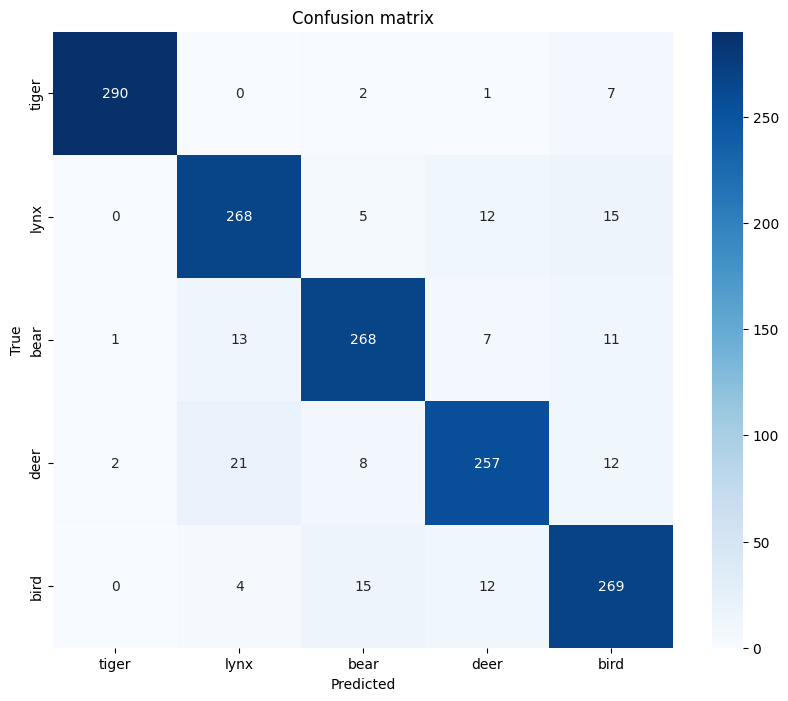

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
confusion_matrix_path = media_dir + '/confusion_matrix.png'
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
plt.show()